<a href="https://colab.research.google.com/github/IvanSerem/ds2-proyecto-agricola/blob/main/DataScienceII.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Analizar eventos climáticos relevantes para el rendimiento agrícola en Argentina y su impacto potencial en los cultivos.

Hoy aplicaremos un flujo de trabajo completo que simula un proyecto real de ciencia de datos y los preparará para su Tercera Entrega. Nuestra misión es transformar un gran volumen de datos crudos en una historia clara y con insights valiosos.

El plan de hoy es el siguiente:

Adquisición de Datos: Partiremos de los datos masivos que obtendremos de la API del USGS, que nos entregó un DataFrame crudo con más de 8,000 terremotos y 30 columnas.

Data Wrangling (Limpieza y Enriquecimiento): Veremos que los datos crudos no son prácticos para el análisis. Realizaremos un proceso de limpieza para seleccionar, renombrar y transformar las columnas más importantes, creando un dataset final, limpio y potente.

EDA y Storytelling (Análisis y Visualización): Con nuestro dataset ya preparado, formularemos preguntas de interés y las responderemos creando visualizaciones efectivas para contar una historia.

¿Por Qué No Usamos Todas las Columnas? La Necesidad de Seleccionar
Al ejecutar .info() sobre nuestro df_terremotos_crudo, vemos una lista de 30 columnas como esta:

1.1. Importación de Librerías y Definición de Parámetros

In [2]:
# Importamos las librerías esenciales
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns

# Configuramos un estilo visual para todos nuestros gráficos
sns.set_theme(style="whitegrid")

# Definimos los parámetros de la petición
url_base = "https://power.larc.nasa.gov/api/temporal/daily/point"
años_a_consultar = list(range(2014, 2024))


1.2. Extracción de Datos en Lotes

In [8]:
import pandas as pd
import requests
import time

# =========================
# Configuración base NASA POWER
# =========================
url_base = "https://power.larc.nasa.gov/api/temporal/daily/point"
años_a_consultar = list(range(2014, 2024))

# Provincias argentinas (capital provincial como punto representativo)
provincias = {
    "Buenos Aires": (-34.61, -58.38),
    "Catamarca": (-28.47, -65.78),
    "Chaco": (-27.45, -58.99),
    "Chubut": (-43.30, -65.10),
    "Córdoba": (-31.42, -64.18),
    "Corrientes": (-27.47, -58.83),
    "Entre Ríos": (-31.73, -60.53),
    "Formosa": (-26.18, -58.17),
    "Jujuy": (-24.18, -65.33),
    "La Pampa": (-36.62, -64.29),
    "La Rioja": (-29.41, -66.86),
    "Mendoza": (-32.89, -68.83),
    "Misiones": (-27.37, -55.90),
    "Neuquén": (-38.95, -68.06),
    "Río Negro": (-40.81, -63.00),
    "Salta": (-24.78, -65.41),
    "San Juan": (-31.53, -68.52),
    "San Luis": (-33.30, -66.34),
    "Santa Cruz": (-51.62, -69.22),
    "Santa Fe": (-31.63, -60.70),
    "Santiago del Estero": (-27.78, -64.27),
    "Tierra del Fuego": (-54.80, -68.30),
    "Tucumán": (-26.82, -65.22)
}

# Acá guardamos TODO (todas las provincias, todos los años)
lista_dataframes = []

print("--- Realizando la petición en lotes (por provincia y por año) con NASA POWER ---")

for provincia, (lat, lon) in provincias.items():
    print(f"\n📍 Provincia: {provincia} | lat={lat}, lon={lon}")

    for anio in años_a_consultar:
        print(f"  Obteniendo datos para el año {anio}...")

        params = {
            "latitude": lat,
            "longitude": lon,
            "start": f"{anio}0101",
            "end": f"{anio}1231",
            "parameters": "T2M,T2M_MAX,T2M_MIN,PRECTOTCORR,WS2M,RH2M",
            "community": "AG",
            "format": "JSON"
        }

        try:
            response = requests.get(url_base, params=params, timeout=60)
            response.raise_for_status()

            payload = response.json()

            # NASA POWER no trae "data": trae "properties/parameter"
            data_params = payload["properties"]["parameter"]

            # data_params: {variable: {YYYYMMDD: valor}}
            df_anual = pd.DataFrame(data_params)

            # convertir índice YYYYMMDD a fecha
            df_anual["date"] = pd.to_datetime(df_anual.index, format="%Y%m%d")
            df_anual["anio"] = anio
            df_anual["provincia"] = provincia
            df_anual["lat"] = lat
            df_anual["lon"] = lon

            lista_dataframes.append(df_anual.reset_index(drop=True))
            print(f"    ✅ Datos {provincia} {anio}: {len(df_anual)} registros.")

            time.sleep(0.2)

        except requests.exceptions.RequestException as e:
            print(f"    ❌ Error en {provincia} {anio}: {e}")


--- Realizando la petición en lotes (por provincia y por año) con NASA POWER ---

📍 Provincia: Buenos Aires | lat=-34.61, lon=-58.38
  Obteniendo datos para el año 2014...
    ✅ Datos Buenos Aires 2014: 365 registros.
  Obteniendo datos para el año 2015...
    ✅ Datos Buenos Aires 2015: 365 registros.
  Obteniendo datos para el año 2016...
    ✅ Datos Buenos Aires 2016: 366 registros.
  Obteniendo datos para el año 2017...
    ✅ Datos Buenos Aires 2017: 365 registros.
  Obteniendo datos para el año 2018...
    ✅ Datos Buenos Aires 2018: 365 registros.
  Obteniendo datos para el año 2019...
    ✅ Datos Buenos Aires 2019: 365 registros.
  Obteniendo datos para el año 2020...
    ✅ Datos Buenos Aires 2020: 366 registros.
  Obteniendo datos para el año 2021...
    ✅ Datos Buenos Aires 2021: 365 registros.
  Obteniendo datos para el año 2022...
    ✅ Datos Buenos Aires 2022: 365 registros.
  Obteniendo datos para el año 2023...
    ✅ Datos Buenos Aires 2023: 365 registros.

📍 Provincia: Cat

1.3. Inspeccionando los Resultados del Bucle

In [20]:
# Verificamos cuántos DataFrames hemos recolectado
# Debería ser uno por cada año que no dio error.
print(f"Se han recolectado {len(lista_dataframes)} DataFrames en total.")

# Inspeccionemos el primer DataFrame de la lista para ver su estructura y contenido
# Este corresponde a los datos del primer año que consultamos (2020)
if lista_dataframes:
    print("\n--- Analizando el PRIMER DataFrame de la lista (datos del año 2020) ---")

    # Seleccionamos el primer elemento de la lista
    primer_df = lista_dataframes[0]

    # Mostramos su forma y sus primeras filas
    print(f"Forma del primer DataFrame: {primer_df.shape}")
    print("Primeras 3 filas:")
    display(primer_df.head(3))


Se han recolectado 230 DataFrames en total.

--- Analizando el PRIMER DataFrame de la lista (datos del año 2020) ---
Forma del primer DataFrame: (365, 11)
Primeras 3 filas:


,T2M,T2M_MAX,T2M_MIN,PRECTOTCORR,WS2M,RH2M,date,anio,provincia,lat,lon
0,27.94,30.52,25.09,23.96,2.83,65.29,2014-01-01,2014,Buenos Aires,-34.61,-58.38
1,24.30,25.51,22.09,14.94,6.22,71.09,2014-01-02,2014,Buenos Aires,-34.61,-58.38
2,21.41,23.97,18.59,0.00,5.18,54.43,2014-01-03,2014,Buenos Aires,-34.61,-58.38


1.4. Consolidación y Verificación Finalmente, unimos todos los DataFrames de nuestra lista en una única tabla maestra con pd.concat y realizamos una primera verificación.

In [21]:
# 1.4. Consolidación y Verificación

# Verificamos que la lista no esté vacía antes de continuar
if lista_dataframes:
    # Unimos todos los DataFrames (todas las provincias y años)
    df_clima_crudo = pd.concat(lista_dataframes, ignore_index=True)

    print("\n--- ¡DataFrame Consolidado Creado Exitosamente! ---")
    print(f"Forma del DataFrame final: {df_clima_crudo.shape}")

    # Información general para un primer diagnóstico
    print("\n--- Información General ---")
    df_clima_crudo.info()

    # Verificación rápida de cobertura
    print("\n--- Verificaciones básicas ---")
    print("Provincias incluidas:", df_clima_crudo["provincia"].nunique())
    print("Años incluidos:", df_clima_crudo["anio"].unique())
    print("Rango de fechas:", df_clima_crudo["date"].min(), "→", df_clima_crudo["date"].max())
else:
    print("No se pudieron cargar los datos.")



--- ¡DataFrame Consolidado Creado Exitosamente! ---
Forma del DataFrame final: (83996, 11)

--- Información General ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83996 entries, 0 to 83995
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   T2M          83996 non-null  float64       
 1   T2M_MAX      83996 non-null  float64       
 2   T2M_MIN      83996 non-null  float64       
 3   PRECTOTCORR  83996 non-null  float64       
 4   WS2M         83996 non-null  float64       
 5   RH2M         83996 non-null  float64       
 6   date         83996 non-null  datetime64[ns]
 7   anio         83996 non-null  int64         
 8   provincia    83996 non-null  object        
 9   lat          83996 non-null  float64       
 10  lon          83996 non-null  float64       
dtypes: datetime64[ns](1), float64(8), int64(1), object(1)
memory usage: 7.0+ MB

--- Verificaciones básicas ---
Provincias incluidas

 Módulo 2: Data Wrangling del Dataset de Terremotos
Recibimos un DataFrame con 30 columnas, muchas con nombres largos (ej. properties.mag) y datos anidados (ej. geometry.coordinates). Nuestra tarea ahora es:

Seleccionar solo las columnas que nos interesan. (Feature Selection)
Renombrar las columnas para que sean más manejables.
Transformar los tipos de datos (como la fecha).
Crear nuevas variables a partir de las existentes (Feature Engine

“A diferencia del dataset de terremotos, el dataset climático proveniente de NASA POWER no presenta estructuras anidadas ni metadata técnica redundante. Por lo tanto, el proceso de data wrangling se enfocó principalmente en la selección de variables climáticas relevantes, la estandarización de nombres y la creación de nuevas variables temporales y derivadas.”

In [22]:
for columna in df_clima_crudo.columns:
  print(columna)

T2M
T2M_MAX
T2M_MIN
PRECTOTCORR
WS2M
RH2M
date
anio
provincia
lat
lon


In [17]:
# ============================================
# MÓDULO 2 – DATA WRANGLING
# Dataset Climático – NASA POWER
# ============================================

import pandas as pd

# ------------------------------------------------
# 1. PARTIMOS DEL DATAFRAME CRUDO
# ------------------------------------------------
# Se asume que df_clima_crudo ya fue creado en el Módulo 1
# (adquisición y consolidación de datos)

print("Forma del DataFrame crudo:")
print(df_clima_crudo.shape)

# ------------------------------------------------
# 2. SELECCIÓN DE COLUMNAS RELEVANTES
# ------------------------------------------------
columnas_relevantes = [
    "T2M",
    "T2M_MAX",
    "T2M_MIN",
    "PRECTOTCORR",
    "WS2M",
    "RH2M",
    "date",
    "anio",
    "provincia",
    "lat",
    "lon"
]

df_clima_limpio = df_clima_crudo[columnas_relevantes].copy()

print("\nColumnas seleccionadas:")
print(df_clima_limpio.columns)

# ------------------------------------------------
# 3. RENOMBRADO DE COLUMNAS (CLARIDAD SEMÁNTICA)
# ------------------------------------------------
df_clima_limpio = df_clima_limpio.rename(columns={
    "T2M": "temp_media",
    "T2M_MAX": "temp_max",
    "T2M_MIN": "temp_min",
    "PRECTOTCORR": "precipitacion",
    "WS2M": "vel_viento",
    "RH2M": "humedad",
    "date": "fecha",
    "anio": "anio",
    "provincia": "provincia",
    "lat": "latitud",
    "lon": "longitud"
})

# ------------------------------------------------
# 4. VERIFICACIÓN GENERAL DEL DATASET
# ------------------------------------------------
print("\n--- Información del DataFrame Limpio ---")
df_clima_limpio.info()

print("\n--- Primeras filas del DataFrame Limpio ---")
df_clima_limpio.head()


Forma del DataFrame crudo:
(83996, 11)

Columnas seleccionadas:
Index(['T2M', 'T2M_MAX', 'T2M_MIN', 'PRECTOTCORR', 'WS2M', 'RH2M', 'date',
       'anio', 'provincia', 'lat', 'lon'],
      dtype='object')

--- Información del DataFrame Limpio ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83996 entries, 0 to 83995
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   temp_media     83996 non-null  float64       
 1   temp_max       83996 non-null  float64       
 2   temp_min       83996 non-null  float64       
 3   precipitacion  83996 non-null  float64       
 4   vel_viento     83996 non-null  float64       
 5   humedad        83996 non-null  float64       
 6   fecha          83996 non-null  datetime64[ns]
 7   anio           83996 non-null  int64         
 8   provincia      83996 non-null  object        
 9   latitud        83996 non-null  float64       
 10  longitud       83996 non-nul

,temp_media,temp_max,temp_min,precipitacion,vel_viento,humedad,fecha,anio,provincia,latitud,longitud
0,27.94,30.52,25.09,23.96,2.83,65.29,2014-01-01,2014,Buenos Aires,-34.61,-58.38
1,24.30,25.51,22.09,14.94,6.22,71.09,2014-01-02,2014,Buenos Aires,-34.61,-58.38
2,21.41,23.97,18.59,0.00,5.18,54.43,2014-01-03,2014,Buenos Aires,-34.61,-58.38
3,24.35,28.11,20.04,0.00,5.16,47.29,2014-01-04,2014,Buenos Aires,-34.61,-58.38
4,26.02,30.74,20.78,0.00,3.16,61.97,2014-01-05,2014,Buenos Aires,-34.61,-58.38


In [18]:
df_clima_limpio["vel_viento_kmh"] = (
    df_clima_limpio["vel_viento"] * 3.6
).round(1)


In [19]:
df_clima_limpio.head()


,temp_media,temp_max,temp_min,precipitacion,vel_viento,humedad,fecha,anio,provincia,latitud,longitud,vel_viento_kmh
0,27.94,30.52,25.09,23.96,2.83,65.29,2014-01-01,2014,Buenos Aires,-34.61,-58.38,10.2
1,24.30,25.51,22.09,14.94,6.22,71.09,2014-01-02,2014,Buenos Aires,-34.61,-58.38,22.4
2,21.41,23.97,18.59,0.00,5.18,54.43,2014-01-03,2014,Buenos Aires,-34.61,-58.38,18.6
3,24.35,28.11,20.04,0.00,5.16,47.29,2014-01-04,2014,Buenos Aires,-34.61,-58.38,18.6
4,26.02,30.74,20.78,0.00,3.16,61.97,2014-01-05,2014,Buenos Aires,-34.61,-58.38,11.4


📊 Módulo 3: EDA y Data Storytelling
Con nuestro dataset limpio y enriquecido, es hora de hacerle preguntas y usar visualizaciones para responderlas y contar una historia.

Pregunta 1: ¿Cómo se distribuye la magnitud de los terremotos significativos?

/tmp/ipython-input-3982519842.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


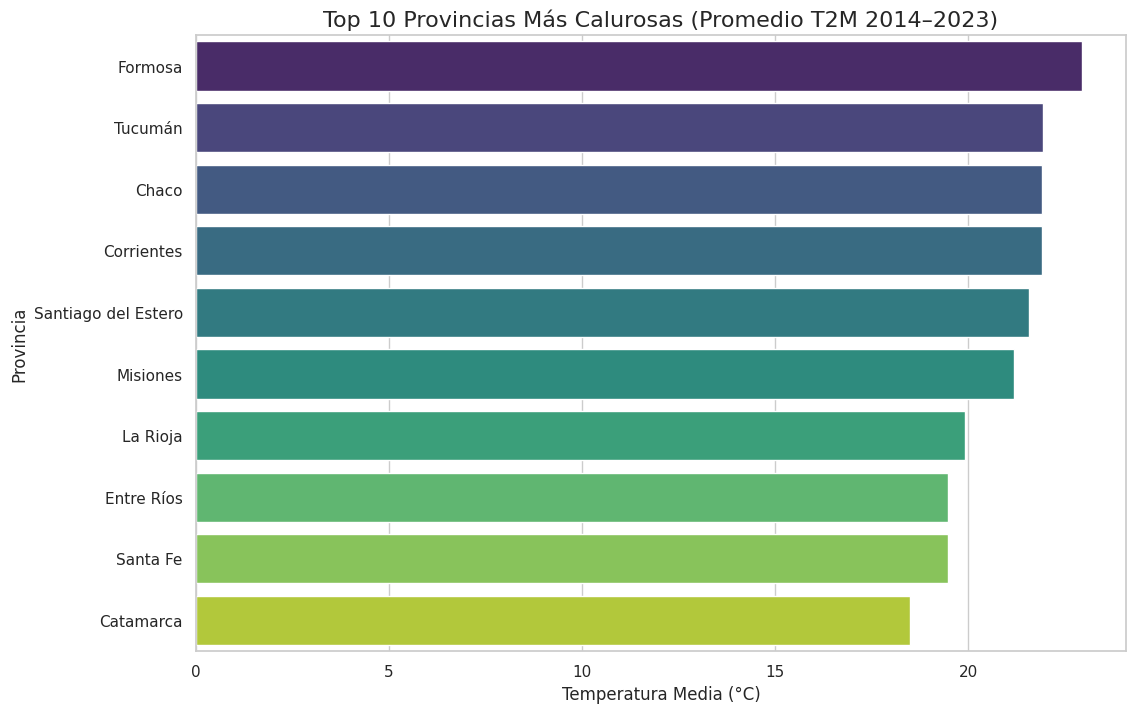

,T2M
provincia,
Formosa,22.944137
Tucumán,21.949762
Chaco,21.917823
Corrientes,21.917823
Santiago del Estero,21.569480
Misiones,21.179644
La Rioja,19.916073
Entre Ríos,19.488267
Santa Fe,19.488267


In [25]:
# ==============================
# TOP 10 PROVINCIAS MÁS CALUROSAS
# ==============================

# 1️⃣ Calculamos la temperatura promedio por provincia
top_10_calor = (
    df_clima_crudo
    .groupby("provincia")["T2M"]
    .mean()
    .sort_values(ascending=False)
    .head(10)
)

# 2️⃣ Visualización
plt.figure(figsize=(12, 8))

sns.barplot(
    y=top_10_calor.index,
    x=top_10_calor.values,
    palette="viridis"
)

plt.title("Top 10 Provincias Más Calurosas (Promedio T2M 2014–2023)", fontsize=16)
plt.xlabel("Temperatura Media (°C)", fontsize=12)
plt.ylabel("Provincia", fontsize=12)

plt.show()

# 3️⃣ Mostrar valores numéricos
display(top_10_calor)


/tmp/ipython-input-1846339240.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


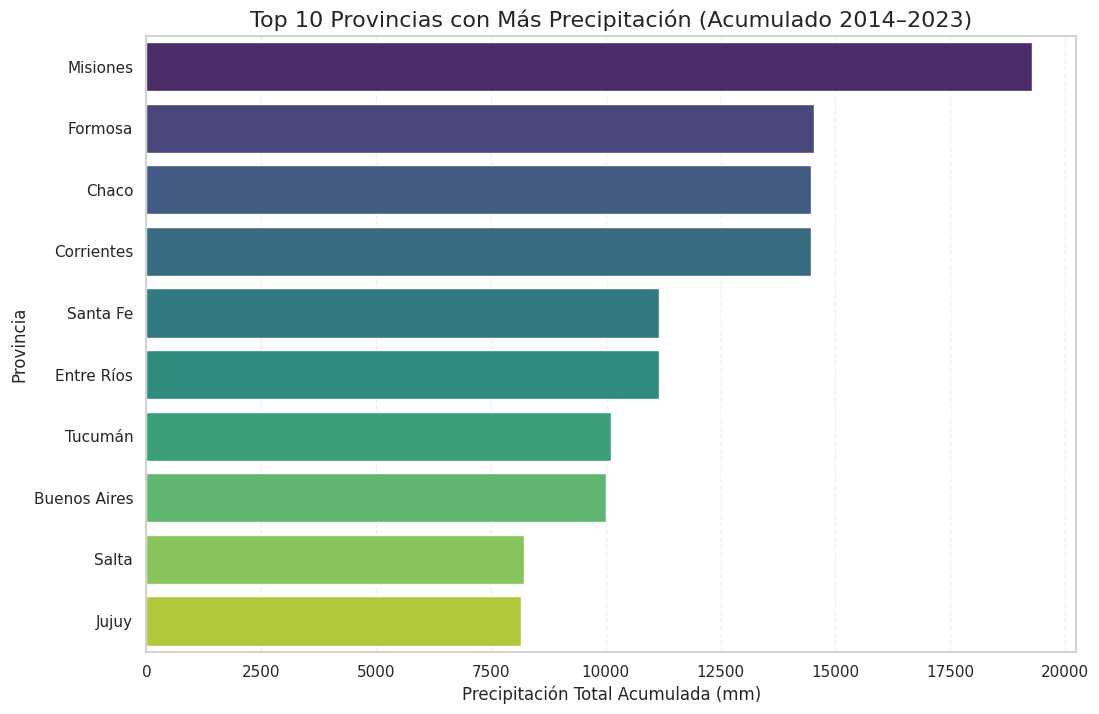

,precipitacion_total_mm
provincia,
Misiones,19279.11
Formosa,14529.04
Chaco,14469.56
Corrientes,14469.56
Santa Fe,11164.28
Entre Ríos,11164.28
Tucumán,10124.12
Buenos Aires,10003.27
Salta,8216.83


In [26]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ==============================
# TOP 10 PROVINCIAS MÁS LLUVIOSAS
# (PRECIPITACIÓN TOTAL ACUMULADA)
# ==============================

# 1) Agregación: suma de precipitación por provincia
top_10_lluvia = (
    df_clima_crudo
    .groupby("provincia")["PRECTOTCORR"]
    .sum()
    .sort_values(ascending=False)
    .head(10)
)

# 2) Plot
plt.figure(figsize=(12, 8))

sns.barplot(
    y=top_10_lluvia.index,
    x=top_10_lluvia.values,
    palette="viridis"
)

plt.title("Top 10 Provincias con Más Precipitación (Acumulado 2014–2023)", fontsize=16)
plt.xlabel("Precipitación Total Acumulada (mm)", fontsize=12)
plt.ylabel("Provincia", fontsize=12)

# 3) Formato de ticks para que se lea mejor
plt.ticklabel_format(style='plain', axis='x')  # evita notación científica
plt.grid(True, axis="x", linestyle="--", alpha=0.3)

plt.show()

# 4) Mostrar valores numéricos
display(top_10_lluvia.to_frame(name="precipitacion_total_mm"))


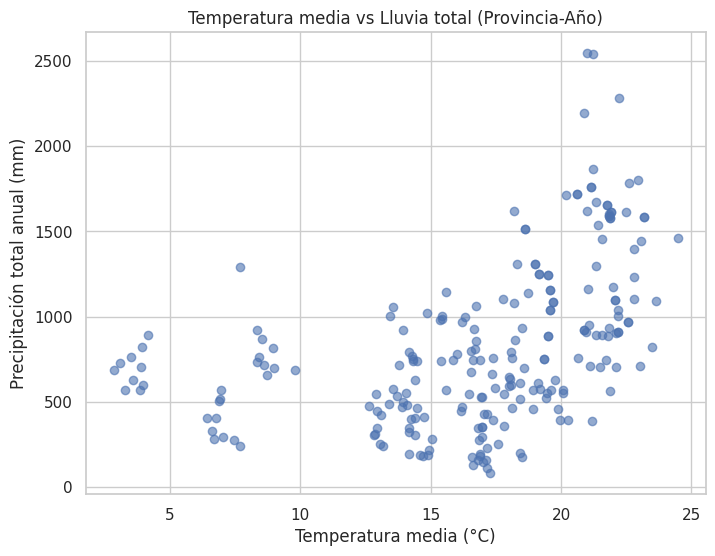

In [28]:
import matplotlib.pyplot as plt

# 1️⃣ Agrupamos por provincia y año
df_simple = (
    df_clima_crudo
    .groupby(["provincia", "anio"], as_index=False)
    .agg(
        temp_media=("T2M", "mean"),
        lluvia_total=("PRECTOTCORR", "sum")
    )
)

# 2️⃣ Creamos gráfico simple
plt.figure(figsize=(8,6))
plt.scatter(df_simple["temp_media"], df_simple["lluvia_total"], alpha=0.6)

plt.title("Temperatura media vs Lluvia total (Provincia-Año)")
plt.xlabel("Temperatura media (°C)")
plt.ylabel("Precipitación total anual (mm)")

plt.show()


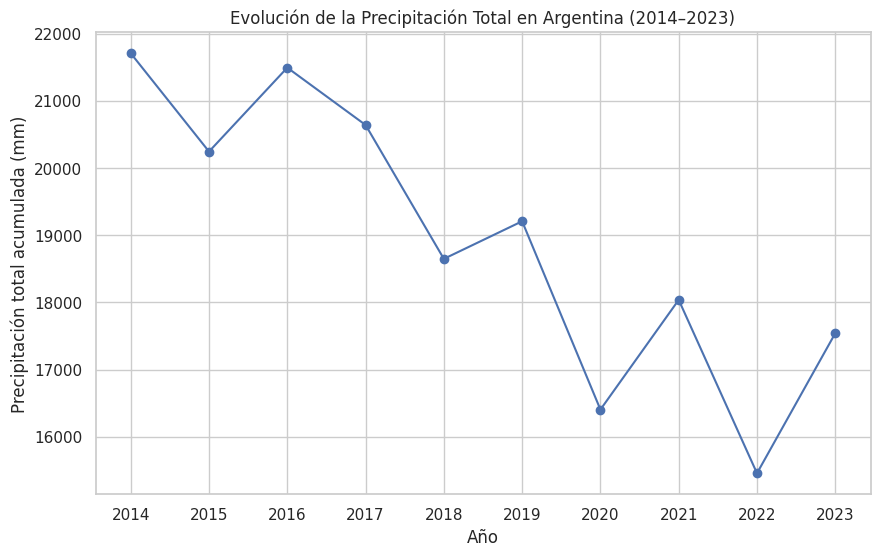

,anio,lluvia_total
0,2014,21708.22
1,2015,20245.08
2,2016,21493.70
3,2017,20640.80
4,2018,18648.44
5,2019,19207.93
6,2020,16405.63
7,2021,18038.44
8,2022,15458.20
9,2023,17541.58


In [29]:
import matplotlib.pyplot as plt

# 1️⃣ Agrupamos por año
lluvia_anual = (
    df_clima_crudo
    .groupby("anio", as_index=False)
    .agg(lluvia_total=("PRECTOTCORR", "sum"))
)

# 2️⃣ Creamos gráfico de línea
plt.figure(figsize=(10,6))
plt.plot(lluvia_anual["anio"], lluvia_anual["lluvia_total"], marker="o")

plt.title("Evolución de la Precipitación Total en Argentina (2014–2023)")
plt.xlabel("Año")
plt.ylabel("Precipitación total acumulada (mm)")
plt.xticks(lluvia_anual["anio"])

plt.show()

# Mostrar valores numéricos
display(lluvia_anual)


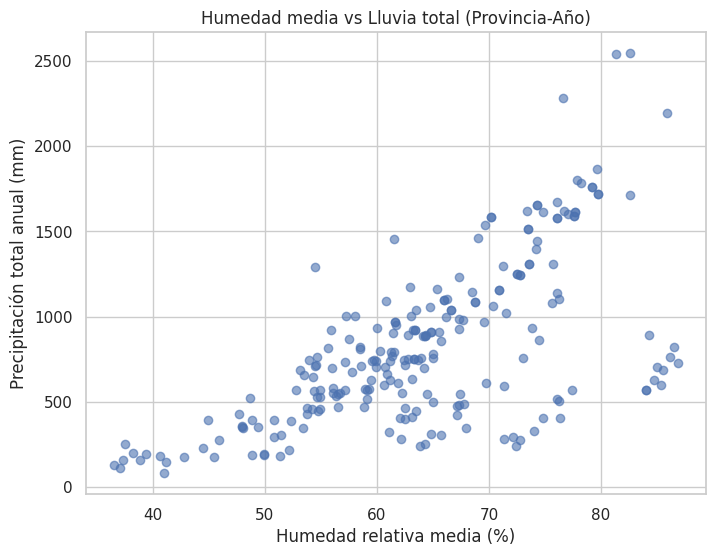

Correlación Pearson: 0.644
Correlación Spearman: 0.634


In [30]:
import matplotlib.pyplot as plt

# 1️⃣ Agrupamos por provincia y año
df_humedad = (
    df_clima_crudo
    .groupby(["provincia", "anio"], as_index=False)
    .agg(
        humedad_media=("RH2M", "mean"),
        lluvia_total=("PRECTOTCORR", "sum"),
        lluvia_media=("PRECTOTCORR", "mean")
    )
)

# 2️⃣ Scatter simple
plt.figure(figsize=(8,6))
plt.scatter(df_humedad["humedad_media"], df_humedad["lluvia_total"], alpha=0.6)

plt.title("Humedad media vs Lluvia total (Provincia-Año)")
plt.xlabel("Humedad relativa media (%)")
plt.ylabel("Precipitación total anual (mm)")

plt.show()

# 3️⃣ Correlación
corr_pearson = df_humedad["humedad_media"].corr(df_humedad["lluvia_total"])
corr_spearman = df_humedad["humedad_media"].corr(df_humedad["lluvia_total"], method="spearman")

print(f"Correlación Pearson: {corr_pearson:.3f}")
print(f"Correlación Spearman: {corr_spearman:.3f}")


¿Llueve todos los días o pocos días concentran toda el agua?

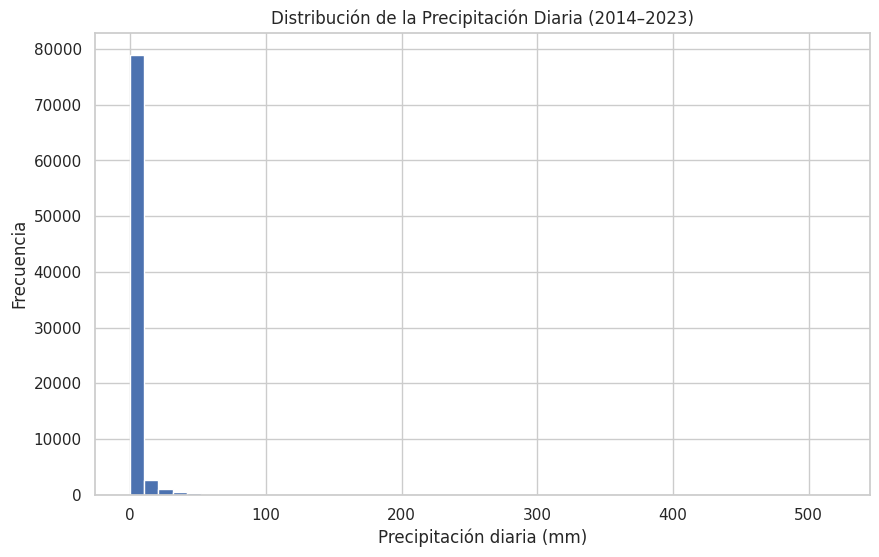

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# ==========================================
# HISTOGRAMA DE PRECIPITACIÓN DIARIA
# ==========================================

plt.figure(figsize=(10,6))

plt.hist(df_clima_crudo["PRECTOTCORR"], bins=50)

plt.title("Distribución de la Precipitación Diaria (2014–2023)")
plt.xlabel("Precipitación diaria (mm)")
plt.ylabel("Frecuencia")

plt.show()


In [32]:
dias_totales = len(df_clima_crudo)
dias_sin_lluvia = (df_clima_crudo["PRECTOTCORR"] == 0).sum()

print("Días totales:", dias_totales)
print("Días sin lluvia:", dias_sin_lluvia)
print("Porcentaje de días sin lluvia:",
      round(dias_sin_lluvia / dias_totales * 100, 2), "%")


Días totales: 83996
Días sin lluvia: 42585
Porcentaje de días sin lluvia: 50.7 %


In [33]:
lluvia_total = df_clima_crudo["PRECTOTCORR"].sum()

dias_intensos = df_clima_crudo[df_clima_crudo["PRECTOTCORR"] > 20]

lluvia_intensa_total = dias_intensos["PRECTOTCORR"].sum()

print("Lluvia total acumulada:", round(lluvia_total, 2), "mm")
print("Lluvia en días intensos (>20mm):", round(lluvia_intensa_total, 2), "mm")
print("Porcentaje del agua que cayó en días intensos:",
      round(lluvia_intensa_total / lluvia_total * 100, 2), "%")


Lluvia total acumulada: 189388.02 mm
Lluvia en días intensos (>20mm): 95260.16 mm
Porcentaje del agua que cayó en días intensos: 50.3 %


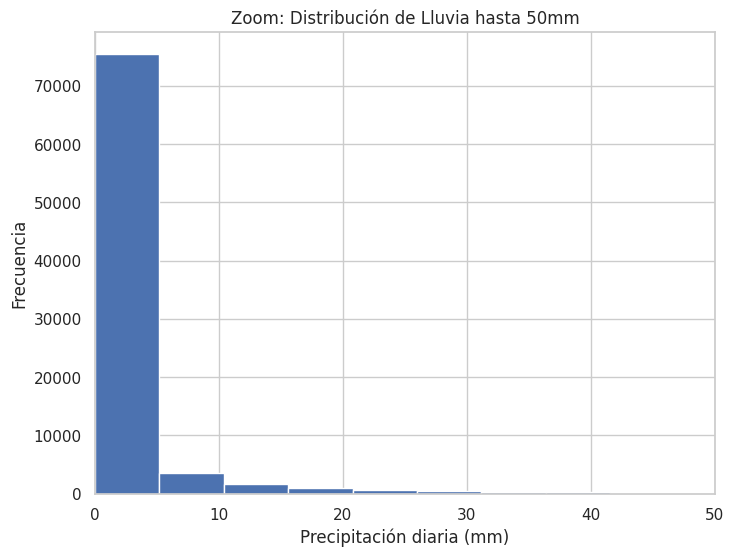

In [34]:
plt.figure(figsize=(8,6))

plt.hist(df_clima_crudo["PRECTOTCORR"], bins=100)
plt.xlim(0, 50)  # Acotamos para ver mejor la zona útil

plt.title("Zoom: Distribución de Lluvia hasta 50mm")
plt.xlabel("Precipitación diaria (mm)")
plt.ylabel("Frecuencia")

plt.show()


¿Cuál es el promedio de lluvia diaria de cada provincia y luego el promedio entre ellas?

In [35]:
# 1️⃣ Promedio diario por provincia
promedio_por_provincia = (
    df_clima_crudo
    .groupby("provincia")
    .agg(lluvia_media=("PRECTOTCORR", "mean"))
)

# 2️⃣ Promedio entre provincias
lluvia_promedio_provincias = promedio_por_provincia["lluvia_media"].mean()

print("Promedio diario entre provincias:",
      round(lluvia_promedio_provincias, 2), "mm/día")

# Mostrar ranking
display(promedio_por_provincia.sort_values("lluvia_media", ascending=False))


Promedio diario entre provincias: 2.25 mm/día


,lluvia_media
provincia,
Misiones,5.279055
Formosa,3.978379
Chaco,3.962092
Corrientes,3.962092
Santa Fe,3.057032
Entre Ríos,3.057032
Tucumán,2.772212
Buenos Aires,2.739121
Salta,2.249953


In [36]:
mediana_lluvia = df_clima_crudo["PRECTOTCORR"].median()

print("Mediana de la precipitación diaria:", round(mediana_lluvia, 2), "mm")


Mediana de la precipitación diaria: 0.0 mm


Top 10 Provincias con Mayor Humedad Promedio (2014-2023):


,RH2M
provincia,
Tierra del Fuego,85.269302
Misiones,77.901386
Santa Cruz,74.390586
Buenos Aires,74.286136
Chaco,72.715775
Corrientes,72.715775
Formosa,71.983686
Santa Fe,68.959608
Entre Ríos,68.959608


/tmp/ipython-input-1366845533.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


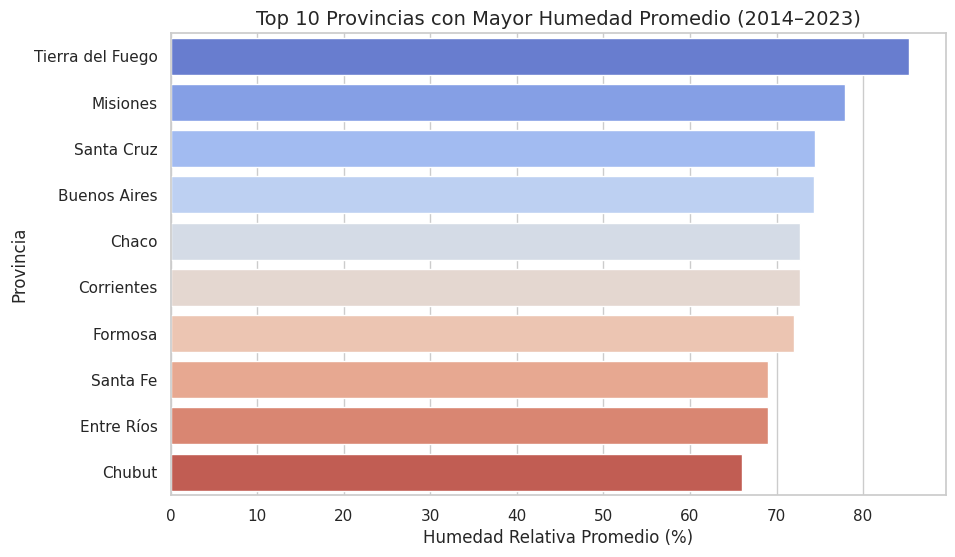

In [37]:
# =========================================
# TOP 10 PROVINCIAS CON MAYOR HUMEDAD
# =========================================

import matplotlib.pyplot as plt
import seaborn as sns

# 1️⃣ Promedio de humedad por provincia
humedad_por_provincia = (
    df_clima_crudo
    .groupby("provincia")["RH2M"]
    .mean()
    .sort_values(ascending=False)
)

# 2️⃣ Top 10
top_10_humedad = humedad_por_provincia.head(10)

print("Top 10 Provincias con Mayor Humedad Promedio (2014-2023):")
display(top_10_humedad)

# 3️⃣ Gráfico
plt.figure(figsize=(10, 6))
sns.barplot(
    x=top_10_humedad.values,
    y=top_10_humedad.index,
    palette="coolwarm"
)

plt.title("Top 10 Provincias con Mayor Humedad Promedio (2014–2023)", fontsize=14)
plt.xlabel("Humedad Relativa Promedio (%)")
plt.ylabel("Provincia")
plt.show()


In [38]:
import numpy as np

# Ordenamos por fecha por seguridad
df_clima_crudo = df_clima_crudo.sort_values("date")

# Creamos variable binaria: 1 si llueve, 0 si no
df_clima_crudo["lluvia_binaria"] = (df_clima_crudo["PRECTOTCORR"] > 0).astype(int)

# Detectamos cambios (cuando empieza o termina una racha)
df_clima_crudo["grupo"] = (
    df_clima_crudo["lluvia_binaria"] != df_clima_crudo["lluvia_binaria"].shift()
).cumsum()

# Nos quedamos solo con los grupos donde hubo lluvia
rachas_lluvia = (
    df_clima_crudo[df_clima_crudo["lluvia_binaria"] == 1]
    .groupby("grupo")
    .size()
)

# Promedio de duración de rachas de lluvia
promedio_racha_lluvia = round(rachas_lluvia.mean(), 2)

print("Promedio de días consecutivos con lluvia:", promedio_racha_lluvia, "días")
print("Cantidad total de rachas detectadas:", len(rachas_lluvia))


Promedio de días consecutivos con lluvia: 2.58 días
Cantidad total de rachas detectadas: 16073


¿Qué provincias tienen más eventos (rachas) de lluvia a lo largo del período 2014–2023?

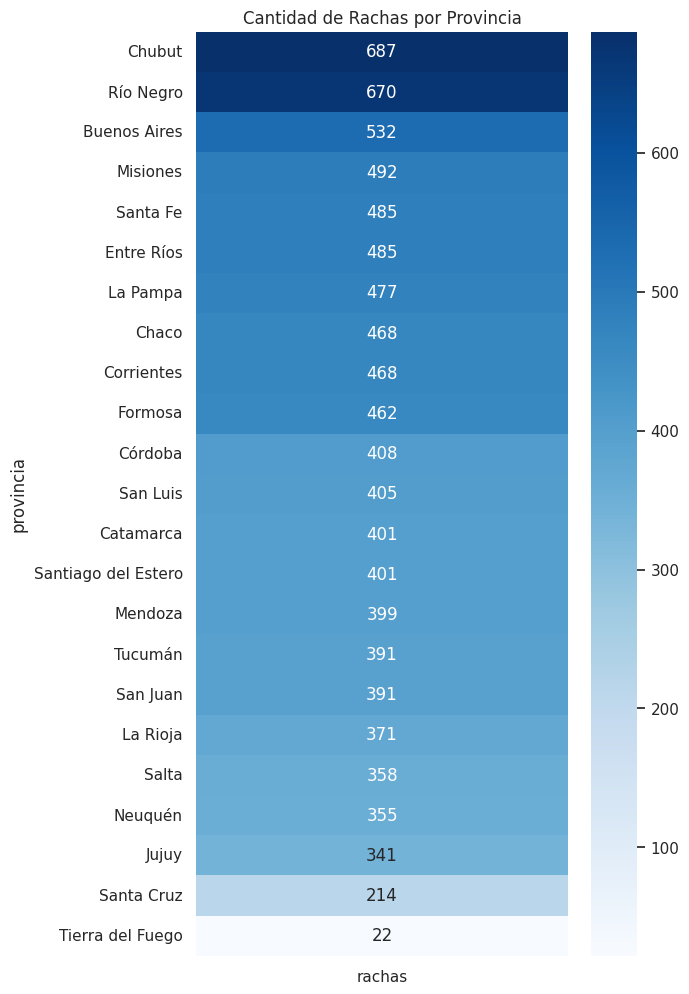

In [42]:
import seaborn as sns

df_heat = rachas_por_provincia.reset_index()
df_heat.columns = ["provincia", "rachas"]

plt.figure(figsize=(6,12))
sns.heatmap(df_heat.set_index("provincia"), cmap="Blues", annot=True, fmt="d")

plt.title("Cantidad de Rachas por Provincia")
plt.show()
